# Building The Design Space for Lyophilization-Edge and Core

In [36]:
#Outputs:
    #Drying Time
    #Product Temperature

#Use this notebook if you want to test only one shelf temperature/chamber pressure combination. 
#Can test either edge or core cases, need to change resistance parameters depending on which case is being tested.
#This notebook can be used as a validation step

In [37]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import math
from mpl_toolkits import mplot3d

### Model Constant Inputs

In [38]:
#Input Parameters
SAin = float(input("Enter Surface Area In(cm^2): ")) #5.982843996
print(SAin)
vial_capac = float(input("Enter Vial Capac: ")) #20
print(vial_capac)
vial_numbers = float(input("Enter Vial Numbers(filled): ")) #86
print(vial_numbers)
ice_den = float(input("Enter Ice Density: ")) #0.918
print(ice_den)
den = float(input("Enter Density: ")) #1.036
print(den)
fill_volume = float(input("Enter Fill Volume(ml): ")) #6.3
print(fill_volume)
water_cont = float(input("Enter Water Content: ")) #0.484
print(water_cont)
Din = float(input("Enter Din: ")) #2.76
print(Din)
Dout = float(input("Enter Dout: ")) #3
print(Dout)
T_critical=float(input("Enter Tcritical: "))
print(T_critical)
dry_cake=(fill_volume*den)/(SAin*ice_den)
print("Dry Cake Initial Height:",dry_cake)
lam=0.00358

Enter Surface Area In(cm^2): 5.982843996
5.982843996
Enter Vial Capac: 20
20.0
Enter Vial Numbers(filled): 86
86.0
Enter Ice Density: 0.918
0.918
Enter Density: 1.036
1.036
Enter Fill Volume(ml): 6.3
6.3
Enter Water Content: 0.484
0.484
Enter Din: 2.76
2.76
Enter Dout: 3
3.0
Enter Tcritical: -20.1
-20.1
Dry Cake Initial Height: 1.1883652534350033


##  Set Shelf Temp/Chamber Pressure

In [39]:
#Set Sampling Rate for Chamber Pressure and Shelf Temperatures(inputs to our model)
T_shelf = float(input("Enter Shelf Temperature(C): ")) #-10
print(T_shelf)
P_chamber = float(input("Enter Chamber Pressure(C): ")) #125
print(P_chamber)

temp=np.array([T_shelf]) #Sample temperature 
press=np.array([P_chamber]) #Sample pressure 

Enter Shelf Temperature(C): -10
-10.0
Enter Chamber Pressure(C): 125
125.0


## Cake Resistance Parameters

Parameters for 2NN : [6.88496101e+00 1.00000101e+05 7.44986665e+00]

Parameters for 3NN : [5.50885891e+00 1.00000068e+05 8.37529548e+00]

Parameters for 4NN : [-9.20522337e+01  9.99973622e+04  6.86547089e+00]

Parameters for core : [4.93983075e+00 1.00000142e+05 7.77494817e+00]

In [40]:
#Set Cake Resistance Parameters
a = float(input("Enter your A parameter for resistance: ")) #-8.85164801e-02
print(a)
b = float(input("Enter your B parameter for resistance: ")) #9.04999955e+04
print(b)
c = float(input("Enter your C parameter for resistance: ")) #6.50812284e+00
print(c)

cake_res_param=np.zeros(3)
cake_res_param[0]=a
cake_res_param[1]=b
cake_res_param[2]=c

Enter your A parameter for resistance: -8.85164801e-02
-0.0885164801
Enter your B parameter for resistance: 9.04999955e+04
90499.9955
Enter your C parameter for resistance: 6.50812284e+00
6.50812284


## Start Iterations

In [41]:
#Create Matrices to Store Predicted Drying Time and Product Temp at Each Pressure/Temp combo
dt=np.zeros((len(temp),len(press)))
tp=np.zeros((len(temp),len(press)))
p_min=np.zeros((len(temp),len(press)))
p_min_param=np.array([5.12,18.829,0])
#Start Iterations
for i in range(len(temp)):
    for j in range(len(press)):
        print("Current Pressure/Temp Combo:",temp[i],"C",press[j],"mTorr")
        
        #Set initial value for percent removed water
        prw_v=0
        #Set counter variable
        count=10
        
        while prw_v<100 and count<60: # keep iterating until prw reaches closest value to 100
            print("Current Iteration:", count-9)
            #Set Initial Arrays that will keep changing in length
            cycle_time=np.arange(18,count+18,1)
            Kv_values=np.repeat(0.00020961432864185497,count) #From Kv Fitting model, doesn't change based on vial configuration
            shelf_temp=np.repeat(temp[i],count) #In degrees Celsius
            cham_pres=np.repeat(press[j]/1000,count) #In Torr

            #OLS Function
            def ols_fit():
                #Define Parameter Set(Initial)
                #T_p_0=((df2[['TC AVG']]).values)[16:count+16] #Used thermocouple average as a starting point for the product temperature fitting
                T_p_0=np.repeat(-45,count)
                #Define Residuals Function
                def residuals(T_p): #T_p is the parameter we are fitting
                    #Need to calculate initial condition for cake resistance and Tice based on initial T_p_0 guess
                    #Go through all steps here
                    #Define function to calculate cake resistance and Tice
                    def intermed(T_p):
                        hf=(shelf_temp-T_p)*Kv_values
                        sh=np.zeros(hf.size)
                        for i in range(len(hf)):
                            if i==0:
                                sh[i]=0
                            else:
                                sh[i]=sh[i-1]+(hf[i]+hf[i-1])*(cycle_time[i]-cycle_time[i-1])*3600/2*Dout*Dout*np.pi/4
                        msi=sh/676
                        pdl=msi/(water_cont*ice_den*Din*Din*np.pi/4)
                        cake_res=(cake_res_param[0]+((cake_res_param[1]*pdl)/(1+cake_res_param[2]*pdl)))/1000 #Use 2NN case for edge
                        Tice_surf=T_p-hf*(dry_cake-pdl)/lam
                        return cake_res, Tice_surf
                    outputs=intermed(T_p) #variable to store cake res and Tice_surf
                    p_pred=np.exp(24.01849-6144.96/(outputs[1].astype("float64")+273.0)) #Have to set initial condition for Tice_surf
                    #p_pred=np.exp(24.01849-6144.96/(outputs[0]+273.0)) #Have to set initial condition for Tice_surf
                    p_real=cham_pres+outputs[0]*3600*((Dout*Dout)/(Din*Din))*Kv_values*(shelf_temp-T_p)/676 #Have to set initial condition for cake_res
                    p_real=np.array(p_real, dtype=float)
                    res=p_pred-p_real
                    return res
                #Least Squares Fitting
                lsq=least_squares(residuals,T_p_0, loss='soft_l1', f_scale=0.1)

                #Fitted Product Temperature
                T_p_fit=lsq.x

                return T_p_fit #final outcome T_p 
            ####   At this point you have fitted product temperature ####
            T_product=ols_fit()

            #Function to calculate all intermediate values used to fit the T_product
            def param(T_p):
                hf=(shelf_temp-T_p)*Kv_values
                sh=np.zeros(hf.size)
                for i in range(len(hf)):
                    if i==0:
                        sh[i]=0
                    else:
                        sh[i]=sh[i-1]+(hf[i]+hf[i-1])*(cycle_time[i]-cycle_time[i-1])*3600/2*Dout*Dout*np.pi/4
                msi=sh/676
                pdl=msi/(water_cont*ice_den*Din*Din*np.pi/4)
                cake_res=cake_res_param[0]+((cake_res_param[1]*pdl)/(1+cake_res_param[2]*pdl)) 
                Tice_surf=T_p-hf*(dry_cake-pdl)/lam
                return cake_res, Tice_surf, hf, msi, sh, pdl

            #Find all intermediate values

            #Heat Flux
            hf_model=param(ols_fit())[2]
            #Sublimation Heat
            sh_model=param(ols_fit())[4]
            #Mass of Sublimed Ice 
            msi_model=param(ols_fit())[3]
            #Product Dried Layer
            pdl_model=param(ols_fit())[5]
            #Cake Resistance
            cake_res_model=param(ols_fit())[0]
            #Tice_surf
            Tice_model=param(ols_fit())[1]

            #Find the sublimation rate
            def sub_rate(HF):
                sr=np.zeros(HF.size)
                for i in range(len(HF)):
                    if i==0:
                        sr[i]=0
                    else:
                        sr[i]=vial_numbers*HF[i]*np.pi*math.pow(Dout,2)/(4*676)
                return sr
            sr=sub_rate(param(ols_fit())[2]) #g/s
            sr_kg=sr*3600/1000

            #Find the percent removed water
            def perc_wat():
                prw = ((((param(ols_fit()))[3]/water_cont)/fill_volume)/den)*100
                return prw 
            prw=perc_wat()

            #Increment the length of necessary variables by one
            count=count+1

            #Set prw_v as the new value
            prw_v=prw[prw.shape[0]-1] #Pick the last element of the prw array

        #Predict Drying Time Using the final output of the for loop for the prw
        drying_time=cycle_time[cycle_time.shape[0]-1]
        print("Drying Time(Hrs):", drying_time)
        #Predict Product Temperature Based on Maximum Temperature in the Array
        product_temp=np.max(T_product)
        print("Product Temperature(C):",product_temp)
        #Predict Pmin based on parameters set
        p_min_model=p_min_param[0]+p_min_param[1]*sr_kg+p_min_param[2]*sr_kg*sr_kg
        #Store Model Predictions for Drying Time and Product Temperature 
        dt[i,j]=drying_time
        tp[i,j]=product_temp
        #Store Pmin
        print("Pmin:",np.max(p_min_model))
        p_min[i,j]=np.max(p_min_model)           

Current Pressure/Temp Combo: -10.0 C 125.0 mTorr
Current Iteration: 1
Current Iteration: 2
Current Iteration: 3
Current Iteration: 4
Current Iteration: 5
Current Iteration: 6
Current Iteration: 7
Current Iteration: 8
Current Iteration: 9
Current Iteration: 10
Current Iteration: 11
Current Iteration: 12
Current Iteration: 13
Current Iteration: 14
Current Iteration: 15
Current Iteration: 16
Drying Time(Hrs): 42
Product Temperature(C): -26.63674630144571
Pmin: 5.378339944168784


## Fitted Product Temperature Plot

Fitted Temperature from OLS:
 [-35.75072637 -30.21886128 -28.83620977 -28.14075762 -27.7174307
 -27.43367995 -27.23220062 -27.08372518 -26.9715978  -26.88558422
 -26.81902351 -26.7673814  -26.72745785 -26.69692645 -26.67405334
 -26.65751869 -26.6462994  -26.63958974 -26.6367463  -26.63724892
 -26.64067247 -26.64666608 -26.65493758 -26.66524175 -26.67737129]


Text(0.5, 1.0, 'Fitted Product Temp From Code')

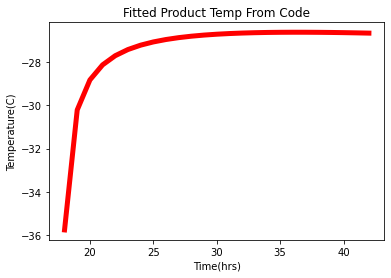

In [42]:
print("Fitted Temperature from OLS:\n",T_product)
plt.plot(cycle_time,T_product,color="red",linewidth=5,label="code")
plt.xlabel("Time(hrs)")
plt.ylabel("Temperature(C)")
plt.title("Fitted Product Temp From Code")

## Final Graphs Output

In [43]:
#Sublimation Rate Function
def sub_rate(HF):
    sr=np.zeros(HF.size)
    for i in range(len(HF)):
        if i==0:
            sr[i]=0
        else:
            sr[i]=vial_numbers*HF[i]*np.pi*math.pow(Dout,2)/(4*676)
    return sr

#Sublimation Rate Calculation
sr=sub_rate(hf_model) #g/s
sr_kg=sr*3600/1000

In [44]:
#Percent Removed Water Function
def perc_wat():
    prw = (((msi_model/water_cont)/fill_volume)/den)*100
    return prw 

#Percent Removed Water Calculation
prw_old=perc_wat()
ind=[]
for i in range(len(prw_old)):
    if prw_old[i]>100:
        ind.append(i)
prw=np.delete(prw_old,ind) #drop values that exceed 100
print("Percent Removed Water:\n",prw)

Percent Removed Water:
 [ 0.          5.74121893 10.61887228 15.23698778 19.71537708 24.10545826
 28.43493825 32.72071179 36.97393822 41.20241849 45.4118435  49.60650595
 53.78973263 57.96416006 62.13191772 66.29475367 70.45412339 74.61125393
 78.76719137 82.92283646 87.0789719  91.23628346 95.39537661 99.55678971]


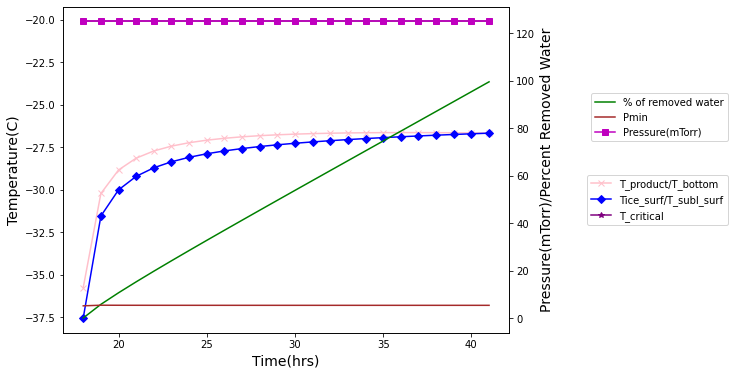

In [45]:
#Plot Final Graph For combined Pressures and Temperatures
pressure=P_chamber 
l=len(prw)
p_min_model=p_min_param[0]+p_min_param[1]*sr_kg+p_min_param[2]*sr_kg*sr_kg
fig,ax = plt.subplots( figsize=(8,6) )
#Temperature axis
# ax.plot(cycle_time[0:l],
#         shelf_temp[0:l],
#         color="red",label="Shelf Temperature(C)")
ax.plot(cycle_time[0:l],
        T_product[0:l],
        color="pink",marker="x",label="T_product/T_bottom") #T_product/T_bottom
ax.plot(cycle_time[0:l],
        Tice_model[0:l],
        color="blue",marker="D",label="Tice_surf/T_subl_surf") #Tice_surf/T_subl_surf
#Change this to real T critical
ax.plot(cycle_time[0:l],
        np.repeat(T_critical,cycle_time.shape[0])[0:l],
        color="purple",marker="*",label="T_critical") #Tcritical
ax.set_xlabel("Time(hrs)", fontsize = 14)
ax.set_ylabel("Temperature(C)", fontsize = 14)
plt.legend(bbox_to_anchor=(1.5,0.5))

#Pressure Axis
ax2=ax.twinx()
ax2.plot(cycle_time[0:l],prw,color="green",label="% of removed water") #Percent Removed Water
ax2.plot(cycle_time[0:l],p_min_model[0:l],color="brown",label="Pmin") #pmin
ax2.plot(cycle_time[0:l],np.repeat(pressure,cycle_time.shape[0])[0:l],color="m",marker="s",label="Pressure(mTorr)") #pressure

ax2.set_ylabel("Pressure(mTorr)/Percent Removed Water", fontsize = 14)
plt.legend(bbox_to_anchor=(1.5,0.75))
plt.show()

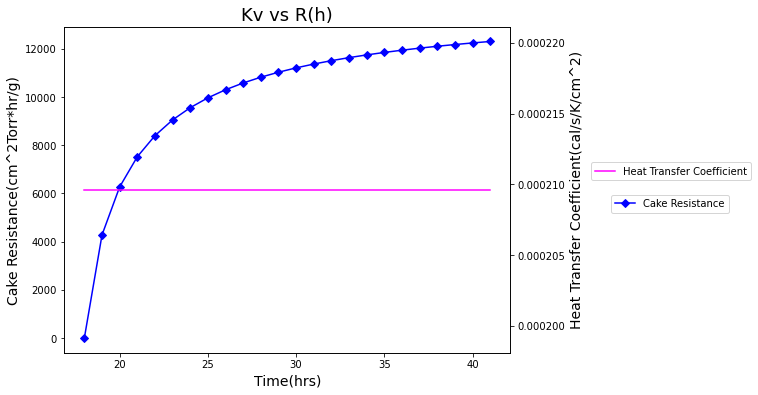

In [46]:
#Plot graph for Kv vs Rh
fig,ax = plt.subplots( figsize=(8,6) )
#Temperature axis
ax.plot(cycle_time[0:l],
        cake_res_model[0:l],
        color="blue",marker="D",label="Cake Resistance")
ax.set_xlabel("Time(hrs)", fontsize = 14)
ax.set_ylabel("Cake Resistance(cm^2Torr*hr/g)", fontsize = 14)
plt.legend(bbox_to_anchor=(1.5,0.5))
ax2=ax.twinx()
ax2.plot(cycle_time[0:l],Kv_values[0:l],color="magenta",label="Heat Transfer Coefficient") #Percent Removed Water
ax2.set_ylabel("Heat Transfer Coefficient(cal/s/K/cm^2)", fontsize = 14)
plt.legend(bbox_to_anchor=(1.55,0.6))
plt.title("Kv vs R(h)",fontsize=18)
plt.show()

# Done